In [3]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(os.path.dirname(project_root))

results_dir = os.path.join(data_dir, 'results')

figures_dir = os.path.join(data_dir, 'figures')

# Summer month

results_basecase_summer = pd.read_csv(os.path.join(results_dir, 'results_basecase_summer.csv'),sep=',')
results_basecase_winter = pd.read_csv(os.path.join(results_dir, 'results_basecase_winter.csv'), sep=',')
results_case_1_winter = pd.read_csv(os.path.join(results_dir, 'results_case_1_winter.csv'), sep=',')
results_case_2_summer = pd.read_csv(os.path.join(results_dir,'results_case_2_summer.csv'), sep=',')
results_case_2_winter = pd.read_csv(os.path.join(results_dir,'results_case_2_winter.csv'), sep=',')
results_case_3_winter = pd.read_csv(os.path.join(results_dir,'results_case_3_winter.csv'), sep=',')
results_case_3_summer = pd.read_csv(os.path.join(results_dir,'results_case_3_summer.csv'), sep=',')


In [5]:
#print column names of all the dfs
#print('results_basecase_summer' , results_basecase_summer.head())
#print('results_case_2_summer' , results_case_2_summer.columns)
#print('results_case_3_summer' , results_case_3_summer.columns)#

In [6]:
import matplotlib.dates as mdates

def plot_energy_profile(
    results_df,
    title="Energy Profile",
    save_filename="energy_profile.png",
    max_time=24 * 7,  # Default to one week
    min_time=0,
    power_dishwasher=1.5,
    power_wm=3,
    power_dryer=3,):

    # Ensure timestamp column is in datetime format
    results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
    timestamps = results_df['timestamp'][min_time:max_time]
    time_range = range(min_time, max_time)

    sns.set_theme(style="whitegrid")
    
    # Extract relevant signals

    binary_dishwasher = results_df['Dishwasher_On']
    binary_wm = results_df['Washing_Machine_On']
    binary_dryer = results_df['Dryer_On']
    soc_ev = results_df['EV_SOC']
    spot_price = results_df['Spotmarket_(EUR/kWh)']
    inflex_demand = results_df['Inflexible_Demand_(kWh)']
    charging_ev = results_df['EV_Charging']
    
    # Build power demand DataFrame
    data_power = pd.DataFrame({
        'timestamp': timestamps,
        'Inflexible Demand': [inflex_demand[t] for t in time_range],
        'Dishwasher': [power_dishwasher * binary_dishwasher[t] for t in time_range],
        'Washing Machine': [power_wm * binary_wm[t] for t in time_range],
        'Dryer': [power_dryer * binary_dryer[t] for t in time_range],
        'EV Charging': [charging_ev[t] for t in time_range]
    })

    if "Heatpump_Power" in results_df.columns:
        data_power['Heat Pump'] = [results_df["Heatpump_Power"][t] for t in time_range]

    data_power_melted = data_power.melt(id_vars='timestamp', var_name='Technology', value_name='Power (kWh)')
    palette = sns.color_palette("tab10", n_colors=len(data_power_melted['Technology'].unique()))

    plt.rcParams.update({
        'axes.titlesize': 16,
        'axes.labelsize': 13,
        'legend.fontsize': 13,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11
    })

    fig, ax1 = plt.subplots(figsize=(10, 7))
    fsns.lineplot(data=data_power_melted, x='timestamp', y='Power (kWh)', hue='Technology', ax=ax1, palette=palette, drawstyle='steps-post')

    ax1.set_ylabel("Hourly Energy Demand (kWh)")
    ax1.set_xlabel("Day")
    ax1.set_xlim(timestamps.iloc[0].normalize(), timestamps.iloc[-1].normalize() + pd.Timedelta(days=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())

    # Spotmarket price
    ax2 = ax1.twinx()
    ax2.plot(timestamps, spot_price[min_time:max_time], '--', color='#a52a2a', label='Spotmarket Price')
    ax2.set_ylabel("Spotmarket Price (EUR/kWh)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # EV SOC
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(timestamps, soc_ev[min_time:max_time] / 70, 'g:', label='EV SOC')
    ax3.set_ylabel("EV SOC", color='black')
    ax3.tick_params(axis='y', labelcolor='black')
    #ax3.set_ylim(0, 1)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()

    legend = ax1.legend(
        lines1 + lines2 + lines3,
        labels1 + labels2 + labels3,
        loc='upper right',
        fontsize=9,
        labelspacing=0.3,
        borderpad=0.3,
        handlelength=1.2,
        handletextpad=0.4,
        borderaxespad=0.5,
        fancybox=True,
        facecolor='#f9f9f9',
    )
    legend.get_frame().set_alpha(0.9)

    plt.title(title)
    plt.tight_layout()
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)

    plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()
  

NameError: name 'fsns' is not defined

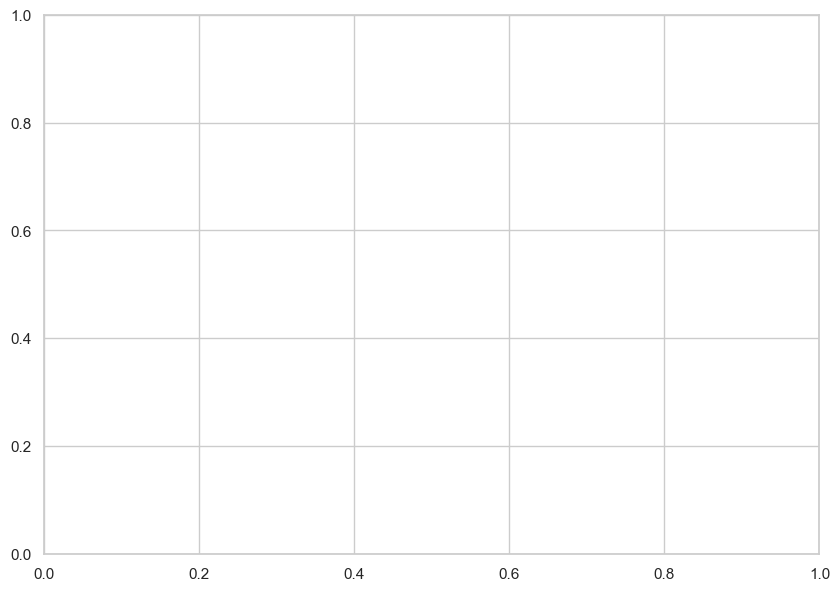

In [7]:
plot_title = "Weekly Demand Profiles (Base Case, Summer Month)"

filename = "basecase_summer.png"

start_day = 7
end_day = 9

plot_energy_profile(
    results_df=results_case_3_winter,
    title=plot_title,
    save_filename= filename,
    max_time=24 * end_day,
    min_time=24 * start_day,
)

In [8]:
min(results_case_3_winter["EV_SOC"][24* 7:24* 9]) / 70



0.03099262345778591

In [74]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import os

def plot_energy_profiles_comparison(
    results_list,
    titles,
    labels=None,
    save_filename="comparison_plot.png",
    min_time=0,
    max_time=24 * 7,
    power_dishwasher=1.5,
    power_wm=3,
    power_dryer=3,
    figsize=(20, 8),
):
    sns.set_theme(style="whitegrid")
    n = len(results_list)
    fig, axes = plt.subplots(ncols=n, sharey=True, figsize=figsize)
    fig.subplots_adjust(left=0.05, right=0.92, bottom=0.12, top=0.92, wspace=0.05)

    if labels is None:
        labels = [f"Case {i+1}" for i in range(n)]

    tech_handles = []
    tech_labels = []
    spot_line = None
    soc_line = None

    for idx, (results_df, ax) in enumerate(zip(results_list, axes)):
        results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
        time_range = range(min_time, max_time)
        timestamps = results_df['timestamp'][min_time:max_time]

        binary_dishwasher = results_df['Dishwasher_On']
        binary_wm = results_df['Washing_Machine_On']
        binary_dryer = results_df['Dryer_On']
        soc_ev = results_df['EV_SOC']
        spot_price = results_df['Spotmarket_(EUR/kWh)']
        inflex_demand = results_df['Inflexible_Demand_(kWh)']
        charging_ev = results_df['EV_Charging']

        data_power = pd.DataFrame({
            'timestamp': timestamps,
            'Inflexible Demand': [inflex_demand[t] for t in time_range],
            'Dishwasher': [power_dishwasher * binary_dishwasher[t] for t in time_range],
            'Washing Machine': [power_wm * binary_wm[t] for t in time_range],
            'Dryer': [power_dryer * binary_dryer[t] for t in time_range],
            'EV Charging': [charging_ev[t] for t in time_range]
        })

        if "Heatpump_Power" in results_df.columns:
            data_power['Heat Pump'] = [results_df["Heatpump_Power"][t] for t in time_range]

        data_power_melted = data_power.melt(
            id_vars='timestamp', var_name='Technology', value_name='Power (kWh)'
        )

        palette = sns.color_palette("tab10", n_colors=len(data_power_melted['Technology'].unique()))
        show_legend = (idx == 0)
        lineplot = sns.lineplot(
            data=data_power_melted, x='timestamp', y='Power (kWh)', hue='Technology',
            ax=ax, palette=palette, drawstyle='steps-post', legend=show_legend
        )

        if show_legend:
            handles, labels_ = ax.get_legend_handles_labels()
            tech_handles = [h for h, l in zip(handles, labels_) if l != "Technology"]
            tech_labels = [l for l in labels_ if l != "Technology"]
            if ax.legend_:
                ax.legend_.remove()

        ax.set_xlabel("")
        ax.set_title(labels[idx], pad=12, fontsize=20)

                # Format timestamps for combined weekday and date label
        ticks = pd.date_range(
        start=timestamps.iloc[0].normalize(),
        end=timestamps.iloc[-1].normalize() + pd.Timedelta(days=1),freq='D'
        )

        tick_labels = [ts.strftime('%a\n%d.%m') for ts in ticks]
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels, fontsize=14)
        ax.tick_params(axis='x', pad=5, labelsize=14)
        ax.grid(False) 
        ax.xaxis.grid(False)  # disable vertical grid lines from explicit xticks


        if idx == 0:
            ax.set_ylabel("Hourly Energy Demand (kWh)", labelpad=10, fontsize=16)
            ax.tick_params(axis='y', labelleft=True, labelsize=14)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis='y', labelleft=False, length=0, labelsize=14)

        ax2 = ax.twinx()
        spot_line, = ax2.plot(
            timestamps, spot_price[min_time:max_time],
            '--', color='#a52a2a', label='Spotmarket Price'
        )
        ax2.grid(False)

        if idx == n - 1:
            ax2.set_ylabel("Spotmarket Price (EUR/kWh)", color='black', labelpad=10, fontsize=16)
            ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
        else:
            ax2.set_ylabel("")
            ax2.set_yticklabels([])
            ax2.tick_params(axis='y', labelright=False, length=0, labelsize=14)
            ax2.spines["right"].set_visible(False)

        ax3 = ax.twinx()
        soc_line, = ax3.plot(
            timestamps, soc_ev[min_time:max_time] / 70,
            ':', color='green', label='EV SOC'
        )
        ax3.set_ylim(0, 1)
        ax3.grid(False)

        if idx == n - 1:
            ax3.spines["right"].set_position(("outward", 80))
            ax3.set_ylabel("EV SOC", color='black', labelpad=10, fontsize=16)
            ax3.tick_params(axis='y', labelright=True, labelcolor='black', labelsize=14)
        else:
            ax3.set_ylabel("")
            ax3.set_yticklabels([])
            ax3.tick_params(axis='y', labelright=False, length=0, labelsize=14)
            ax3.spines["right"].set_visible(False)

    legend_items = tech_handles + [spot_line]
    legend_labels_combined = tech_labels + ['Spotmarket Price']
    if soc_line:
        legend_items.append(soc_line)
        legend_labels_combined.append('EV SOC')

    fig.legend(
        handles=legend_items,
        labels=legend_labels_combined,
        loc='lower center',
        bbox_to_anchor=(0.515, -0.08),
        ncol=len(legend_labels_combined),
        fontsize=14,
        frameon=True
    )

    fig.supxlabel("Day", fontsize=16, x=0.489)
    #plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()

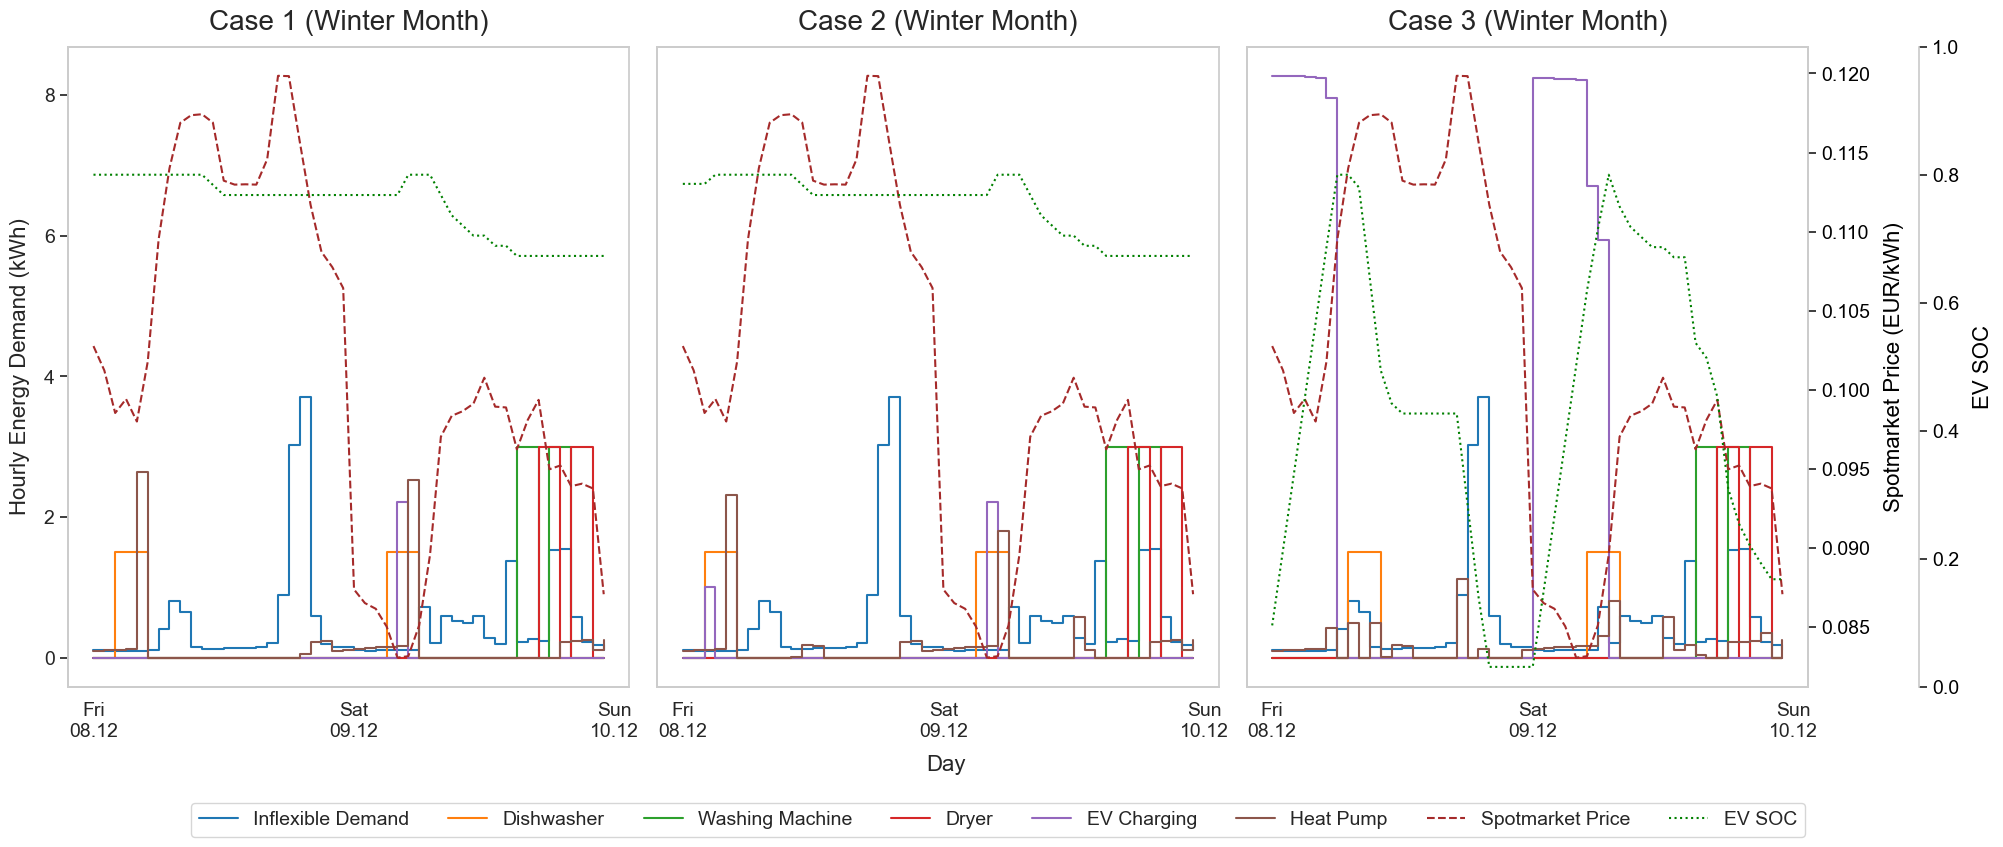

In [75]:

plot_energy_profiles_comparison(
    results_list=[results_case_1_winter, results_case_2_winter, results_case_3_winter],
    titles="Comparison of Weekly Demand Profiles (Winter)",
    labels=["Case 1 (Winter Month)", "Case 2 (Winter Month)","Case 3 (Winter Month)"],
    save_filename="winter_comparison.png",
    min_time=24*7,
    max_time=24*9
)